In [2]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
import main

## Load data

##TODO make a parameter file that suits this case of checking different quantile postprocessing. 

In [6]:
params_path = '../params/params_competition_gefcom2014_solar_example.json'
with open(params_path, 'r', encoding='utf-8') as file:
    params_json = json.loads(file.read())

df = main.load_data('.'+params_json['path_preprocessed_data']+params_json['filename_preprocessed_data'])

In [9]:
trial = main.Trial(params_json)
dfs_X_train_farm, dfs_y_train_farm, dfs_model_train_farm, weight_train_farm = trial.generate_dataset_farm_split(df, split_set='train')
dfs_X_valid_farm, dfs_y_valid_farm, dfs_model_valid_farm, weight_valid_farm = trial.generate_dataset_farm_split(df, split_set='valid')
gbm_farm, evals_result_farm = trial.train_farm_split(dfs_model_train_farm, weight_train_farm=weight_train_farm, dfs_model_valid_farm=dfs_model_valid_farm)   

  0%|          | 0/6 [00:00<?, ?it/s]

Generating dataset...


 50%|█████     | 3/6 [00:00<00:00, 22.19it/s]

Generating dataset...


  0%|          | 0/6 [00:00<?, ?it/s]

Training...


100%|██████████| 6/6 [00:17<00:00,  2.85s/it]


In [10]:
dfs_y_pred_train_farm = trial.predict_farm_split(dfs_X_train_farm, gbm_farm)
dfs_y_pred_valid_farm = trial.predict_farm_split(dfs_X_valid_farm, gbm_farm)

 33%|███▎      | 2/6 [00:00<00:00, 10.93it/s]

Predicting...


 33%|███▎      | 2/6 [00:00<00:00, 17.62it/s]

Predicting...


100%|██████████| 6/6 [00:00<00:00, 26.32it/s]


[[{'lightgbm':                                              mean
   ref_datetime        valid_datetime               
   2013-04-01 01:00:00 2013-04-01 01:00:00  0.716077
                       2013-04-01 02:00:00  0.721243
                       2013-04-01 03:00:00  0.686017
                       2013-04-01 04:00:00  0.571658
                       2013-04-01 05:00:00  0.421729
   ...                                           ...
   2013-04-30 01:00:00 2013-04-30 20:00:00  0.044575
                       2013-04-30 21:00:00  0.044575
                       2013-04-30 22:00:00  0.084655
                       2013-04-30 23:00:00  0.231925
                       2013-05-01 00:00:00  0.464496
   
   [720 rows x 1 columns],
   'xgboost':                                              mean
   ref_datetime        valid_datetime               
   2013-04-01 01:00:00 2013-04-01 01:00:00  0.775073
                       2013-04-01 02:00:00  0.771891
                       2013-04-01 03:00:00  0

In [17]:
regression_params = params_json['regression_params']
train_on_day_only = params_json['train_on_day_only']
diff_target_with_physical = params_json['diff_target_with_physical']
dfs_X_split = dfs_X_test_split

In [21]:
regression_params = params_json['regression_params']
dfs_X_split = dfs_X_test_split

columns = []
if 'mean' in regression_params['type']:
    columns.append('mean')

if 'quantile' in regression_params['type']:
    alpha_q = np.arange(regression_params['alpha_range'][0],
                        regression_params['alpha_range'][1],
                        regression_params['alpha_range'][2])
    columns.extend(['quantile{0}'.format(int(100*alpha)) for alpha in alpha_q])

dfs_y_pred_split = []
for idx_split, (dfs_X_farm, gbm_farm) in enumerate(zip(dfs_X_split, gbm_split)):
    print('Predicting split: {0}.'.format(idx_split+1))

    dfs_y_pred_farm = []
    for df_X, gbm_q, in zip(dfs_X_farm, gbm_farm):

        df_y_pred_q = pd.DataFrame(index=df_X.index, columns=columns)

        # Keep all timestamps for which zenith <= 100° (day timestamps)
        if train_on_day_only:
            idx_day = df_X['zenith'] <= 100
            idx_night = df_X['zenith'] > 100
            df_X = df_X[idx_day]

        y_pred_q = []
        for gbm in gbm_q:
            y_pred = gbm.predict(df_X)
            if diff_target_with_physical: 
                y_pred = y_pred+df_X['Physical_Forecast'].values

            y_pred_q.append(y_pred)

        # Convert list to numpy 2D-array
        y_pred_q = np.stack(y_pred_q, axis=-1)

        # Lazy post-sorting of quantiles
        # TODO: Find other ways of making sure we have monotonicity of quantiles
        #y_pred_q = np.sort(y_pred_q, axis=1)

        if train_on_day_only:
            df_y_pred_q[idx_day] = y_pred_q
            df_y_pred_q[idx_night] = 0
        else:
            df_y_pred_q.values[:] = y_pred_q

        dfs_y_pred_farm.append(df_y_pred_q)

    dfs_y_pred_split.append(dfs_y_pred_farm)

Predicting split: 1.
Predicting split: 2.
Predicting split: 3.
Predicting split: 4.
Predicting split: 5.
Predicting split: 6.
Predicting split: 7.
Predicting split: 8.
Predicting split: 9.
Predicting split: 10.
Predicting split: 11.
Predicting split: 12.
Predicting split: 13.
Predicting split: 14.
Predicting split: 15.


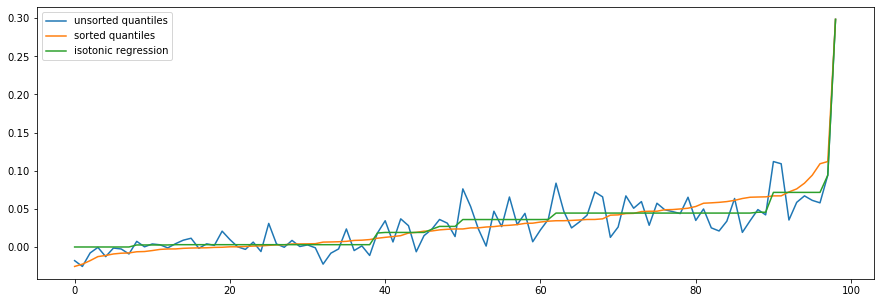

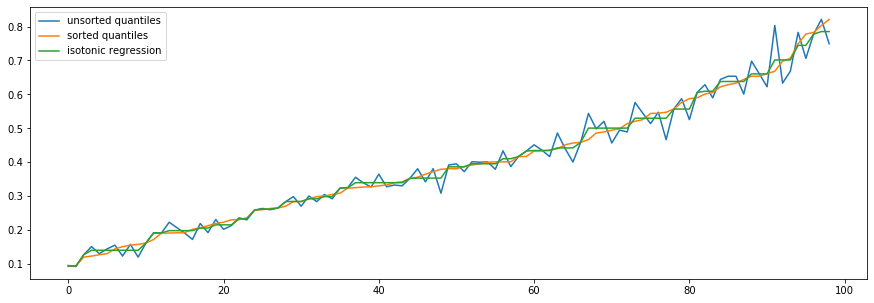

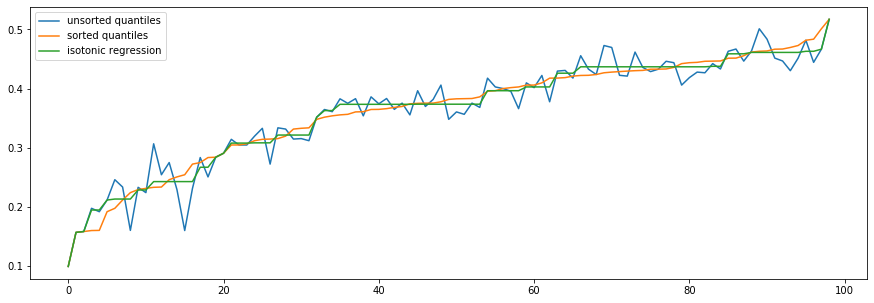

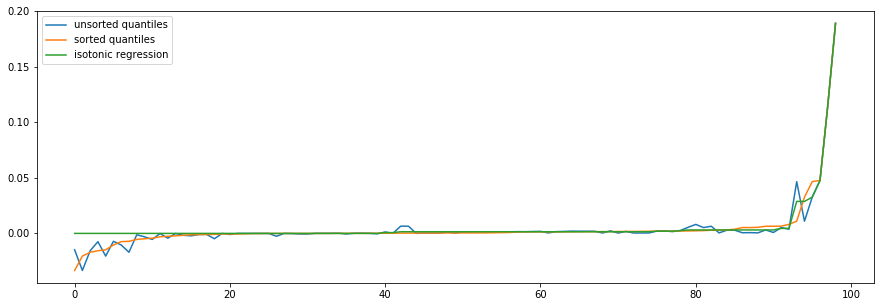

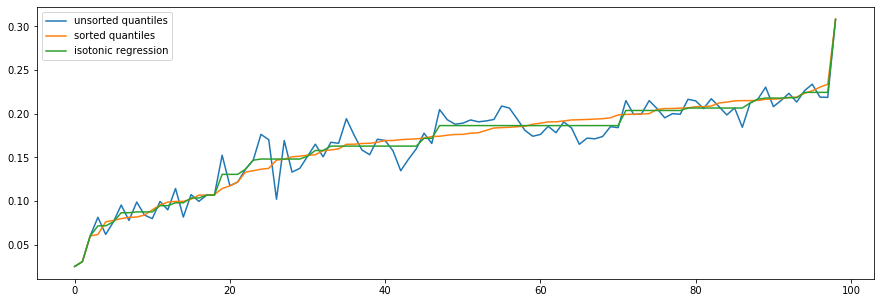

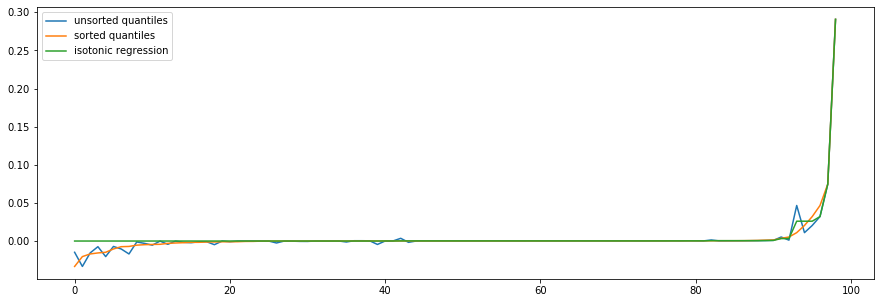

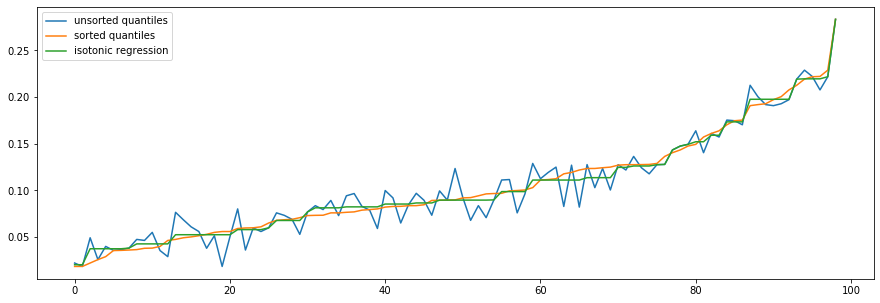

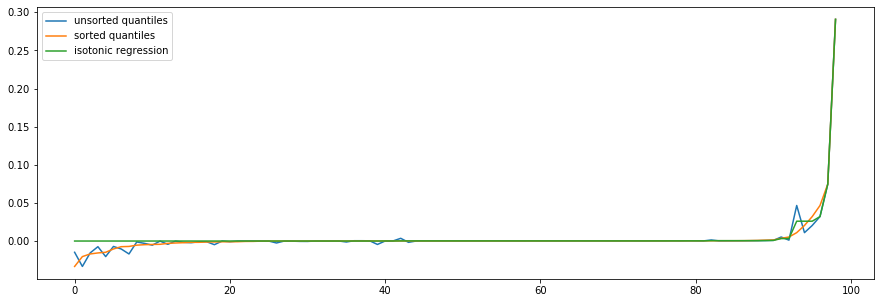

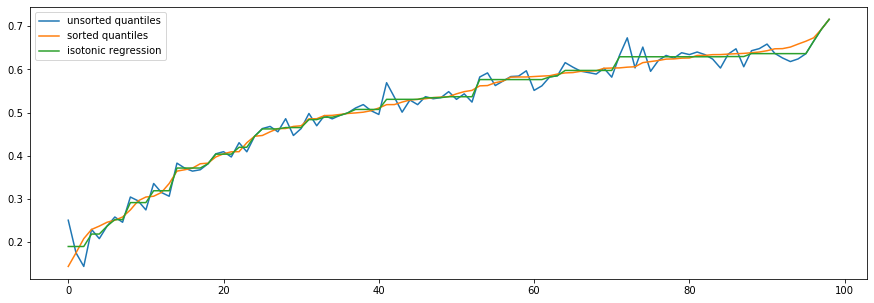

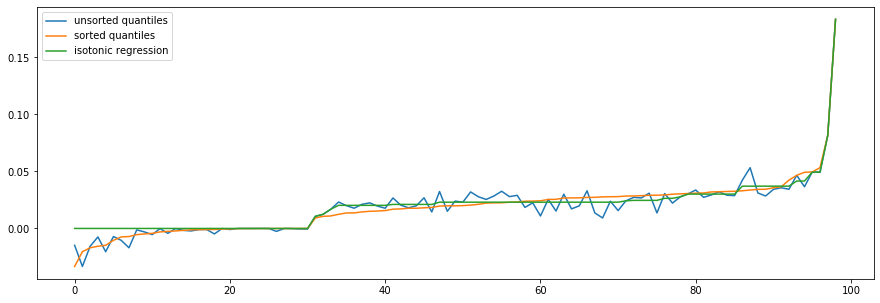

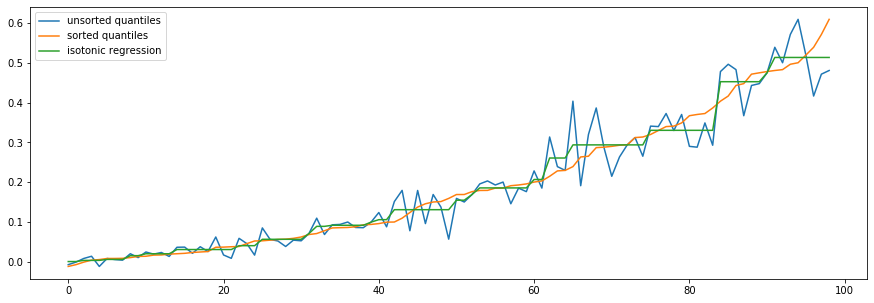

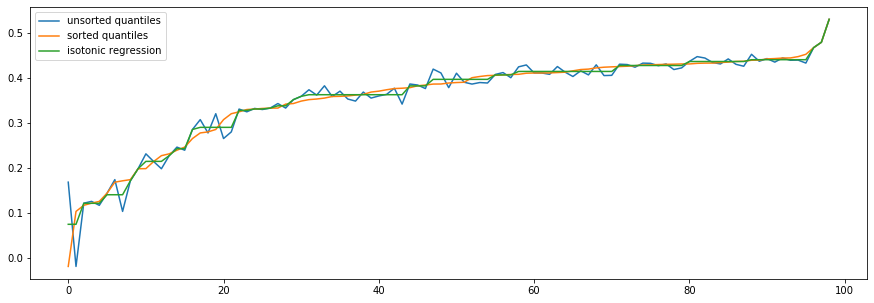

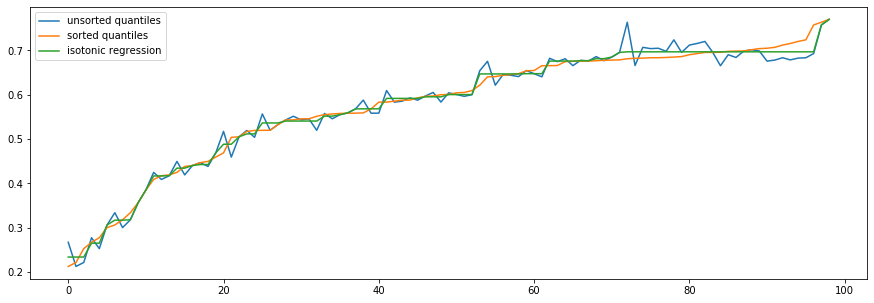

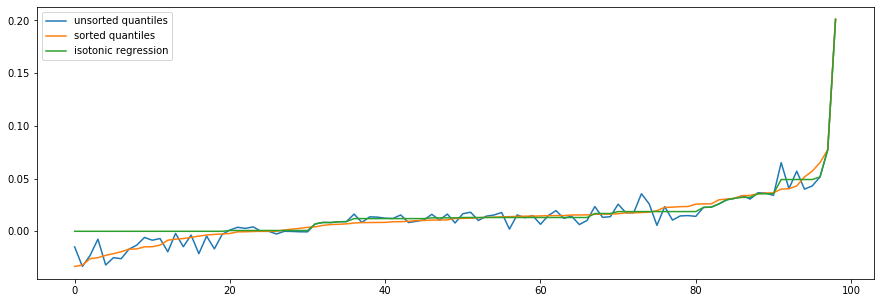

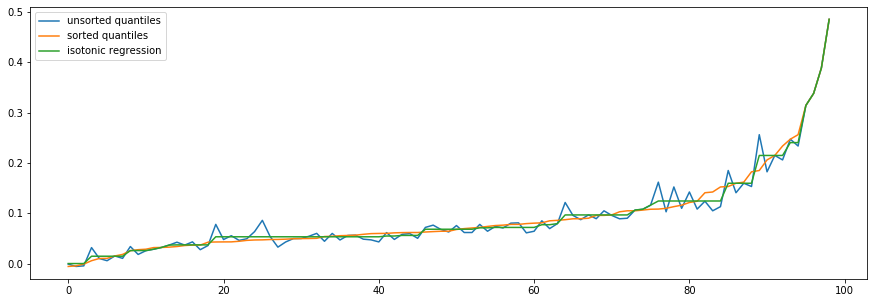

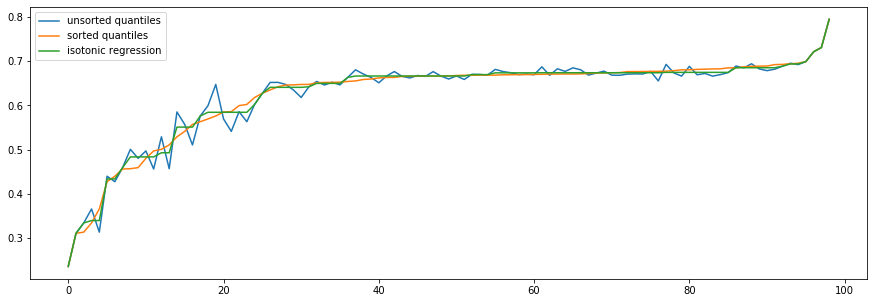

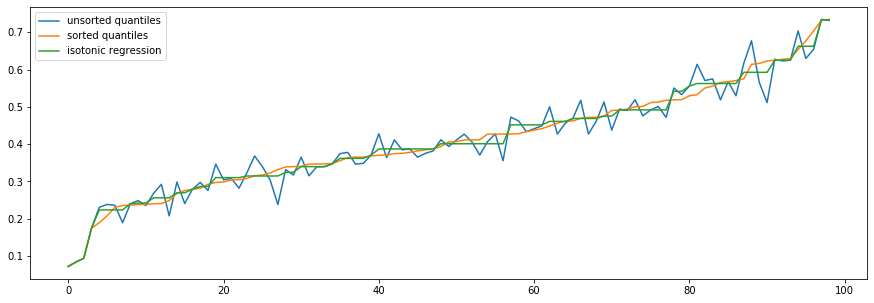

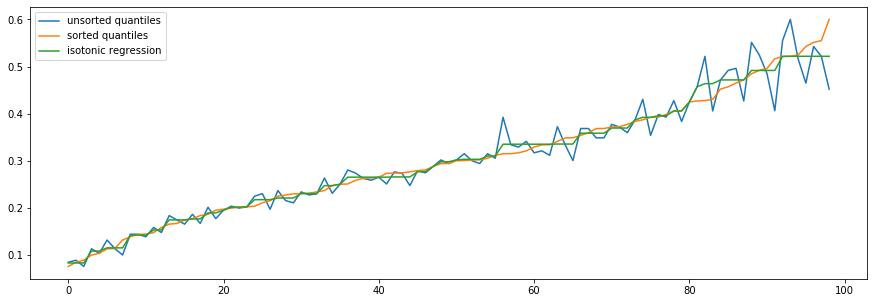

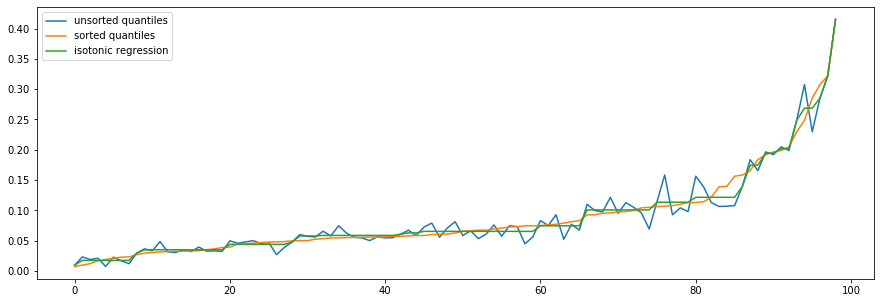

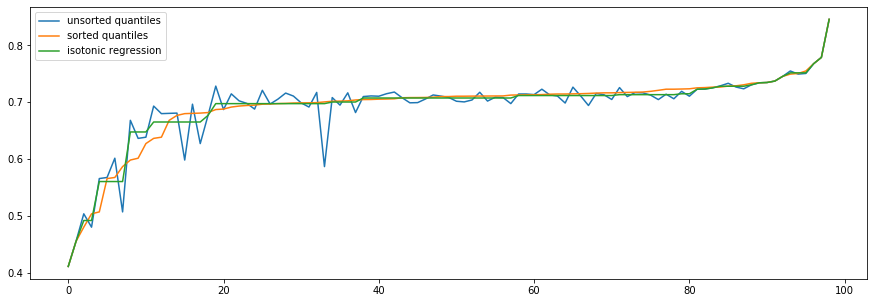

In [167]:
samples = np.random.randint(0, high=y_pred_q.shape[0], size=20)
for sample in samples:
    plt.figure(figsize=(15,5))
    plt.plot(y_pred_q[sample,:], label='unsorted quantiles')
    plt.plot(y_pred_q_sort[sample,:], label='sorted quantiles')
    
    regressor = IsotonicRegression(y_min=0, y_max=1)
    x = np.arange(0.01,1,0.01)
    y_iso = regressor.fit_transform(x, y_pred_q[sample,:])
    plt.plot(y_iso, label='isotonic regression')
    
    
    plt.legend()
    plt.show()